In [40]:
#Kolminkertainen eksponentiaalinen tasoitus
#Kolminkertaista eksponentiaalista tasoitusta kutsutaan myös Holt-Winterin malliksi. Eksponentiaalisen tasoituksen mallit (yksinkertainen, kaksinkertainen ja kolminkertainen) ovat erityisen suosittuja liiketaloudessa kysynnän ennustamisessa. Mallit ovat helppokäyttöisiä, nopeasti laskettavissa ja helposti päivitettävissä uusien havaintojen myötä.
#Holt-Winterin malli huomioi sekä trendin että kausivaihtelun.
#Eksponentiaalinen tasoitus löytyy statsmodels.tsa-kirjastosta.
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.api import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-whitegrid')
%matplotlib inline

In [41]:
df=pd.read_csv('http://taanila.fi/AirPassengers.csv')
df.index=pd.to_datetime(df['Month'],format='%Y-%m')
df=df.drop('Month',axis=1)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


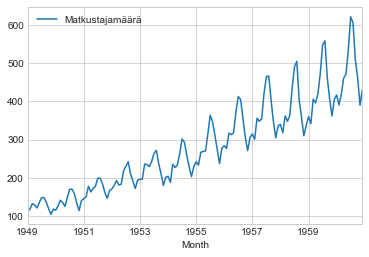

In [43]:
df = df.rename(columns = {'#Passengers': 'Matkustajamäärä'})
df.plot()

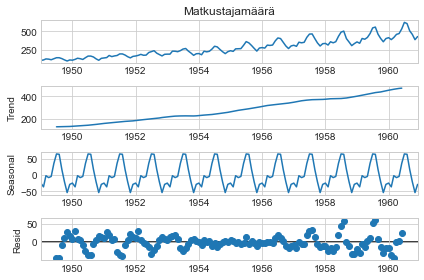

In [26]:
# Aikasarjan vaihtelua aiheuttavien komponenttien erottelu
# Observed=alkuperäinen aikasarja, Trend=trendi, Seasonal=kausivaihtelu,
# Residual=muu kuin trendiin ja kausivaihteluun liittyvä vaihtelu
# Alimmassa aikasarjassa on selvästi havaittavat trendi ja kausivaihtelu. Koska kyse on vuorokausidatasta, niin kausivaihtelu esiintyy neljän havainnon (40 päivän) jaksoissa.
decompose = seasonal_decompose(df['Matkustajamäärä']).plot()

In [27]:
#Mallin sovitus
#Ennustemalli sovitetaan (fit()) dataan. Tuloksena saadaan olio (tässä olen antanut oliolle nimeksi malli), joka sisältää monenlaista tietoa mallista.
#Trendiin (trend) käytän summamallia (add), jossa trendi on aikasarjaan lisättävä termi. Tämä on suositeltavin vaihtoehto.
#Kausivaihteluun (seasonal) käytän summamallia (add) tai tulomallia (mul). Tulomallissa kausivaihtelu ilmenee kertoimina. Tässä olen kokeillut myös summamallia, mutta tulomalli osoittautui paremmaksi.
#seasonal_periods-parametrille käytän arvoa 4, koska kausivaihtelu esiintyy neljän vuosineljänneksen jaksoissa.
#freq-parametrille käytän arvoa 'MS', koska kyseessä ovat kuukauden ensimmäiset päivät. Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
malli = ExponentialSmoothing(df['Matkustajamäärä'], trend = 'add', seasonal = 'mul', 
                             seasonal_periods = 4, freq='MS').fit()

In [28]:
# malli-olion avulla saan mallin mukaan simuloidut ennusteet (fittedvalues) jo toteutuneille ajankohdille
df['Ennuste'] = malli.fittedvalues
df

,Matkustajamäärä,Ennuste
Month,,
1949-01-01,112,120.555858
1949-02-01,118,116.477013
1949-03-01,132,124.161397
1949-04-01,129,130.962494
1949-05-01,121,124.400512
...,...,...
1960-08-01,606,648.479425
1960-09-01,508,586.703454
1960-10-01,461,507.229659


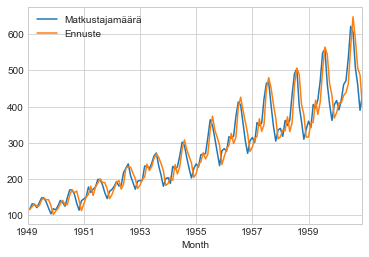

In [29]:
# Alkuperäinen aikasarja ja mallin mukaiset ennusteet samaan kaavioon
df.plot()

In [30]:
# Ennustevirheet (residuaalit) löytyvät malli-oliosta
df['Ennustevirhe'] = malli.resid
df

,Matkustajamäärä,Ennuste,Ennustevirhe
Month,,,
1949-01-01,112,120.555858,-8.555858
1949-02-01,118,116.477013,1.522987
1949-03-01,132,124.161397,7.838603
1949-04-01,129,130.962494,-1.962494
1949-05-01,121,124.400512,-3.400512
...,...,...,...
1960-08-01,606,648.479425,-42.479425
1960-09-01,508,586.703454,-78.703454
1960-10-01,461,507.229659,-46.229659


Text(0, 0.5, 'Ennustevirhe')

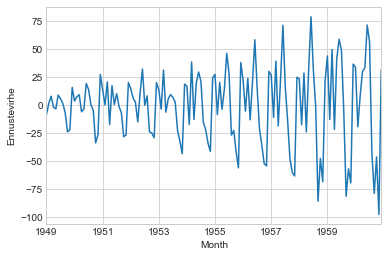

In [31]:
#Mallin tarkastelu
#Mallin hyvyyden tarkasteluun on monia tapoja. Tässä käytän
#ennustevirheiden aikasarjaa viivakaaviona
#ennusteiden ja toteutuneiden arvojen hajontakaaviota
#malliin liittyvää statistiikkaa, jonka saan summary()-toiminnolla.
#Huomaa erityisesti SSE (sum of squared errors). Mallia laskeva algoritmi yrittää saada SSE:n mahdollisimman pieneksi.
# Ennustevirheet aikasarjana
# On hyvä, jos ennustevirheiden aikasarjan vaihtelu on sattumanvaraista
df['Ennustevirhe'].plot()
plt.ylabel('Ennustevirhe')

Text(0, 0.5, 'Toteutunut kysyntä')

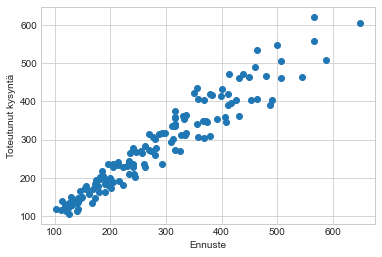

In [32]:
# Ennusteiden ja toteutuneiden kysyntöjen hajontakaavio
# Ennustemalli on sitä parempi, mitä paremmin pisteet seuraavat suoraa viivaa
# vasemmasta alakulmasta oikeaan yläkulmaan
plt.scatter(x = df['Ennuste'], y = df['Matkustajamäärä'])
plt.xlabel('Ennuste')
plt.ylabel('Toteutunut kysyntä')

In [33]:
malli.summary()

Dep. Variable:,endog,No. Observations:,144
Model:,ExponentialSmoothing,SSE,156385.456
Optimized:,True,AIC,1022.598
Trend:,Additive,BIC,1046.357
Seasonal:,Multiplicative,AICC,1024.252
Seasonal Periods:,4,Date:,"Fri, 15 Jan 2021"
Box-Cox:,False,Time:,14:31:23
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9473684,alpha,True
smoothing_slope,0.0526316,beta,True


In [34]:
#Ennusteiden laskeminen
#Ennustettavien ajankohtien aikaleimojen määrittämiseksi:
#Ensimmäisen ennustettavan ajankohdan aikaleiman täytyy olla aikasarjan viimeisintä aikaleimaa seuraava aikaleima.
#Ennustettavien ajankohtien lukumäärän voin määrittää periods-parametrilla.
#Ennustettavien ajankohtien frekvenssin on oltava sama kuin mallia sovitettaessa käytetty freq-parametrin arvo.
#Lisätietoa freq-parametrin mahdollisista arvoista https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases
#Tarkistan viimeisen aikaleiman
df.tail()

,Matkustajamäärä,Ennuste,Ennustevirhe
Month,,,
1960-08-01,606,648.479425,-42.479425
1960-09-01,508,586.703454,-78.703454
1960-10-01,461,507.229659,-46.229659
1960-11-01,390,487.420368,-97.420368
1960-12-01,432,400.753721,31.246279


In [35]:
# Ennustettavien ajankohtien aikaleimat (alkupäivänä aikasarjan viimeistä aikaleimaa seuraava aikaleima)
index = pd.date_range('1961-01-01', periods = 12, freq = 'MS')

# Ennusteet 12 kuukaudelle
ennusteet = malli.forecast(12)

# Ennusteet dataframeen
df_ennuste = pd.DataFrame(data = ennusteet, index = index, 
                          columns = ['Ennuste'])
df_ennuste

,Ennuste
1961-01-01,406.639001
1961-02-01,399.106981
1961-03-01,414.371327
1961-04-01,426.449384
1961-05-01,402.939792
1961-06-01,395.468015
1961-07-01,410.584552
1961-08-01,422.543308
1961-09-01,399.240582
1961-10-01,391.829049


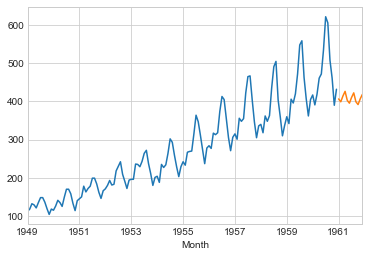

In [36]:
# Viivakaavio havainnoista
df['Matkustajamäärä'].plot()

# Ennusteet kaavioon
df_ennuste['Ennuste'].plot()

In [37]:
# Dataframe, jossa alkuperäinen aikasarja ja lasketut ennusteet
df1 = pd.concat([df, df_ennuste])
df1

,Matkustajamäärä,Ennuste,Ennustevirhe
1949-01-01,112.0,120.555858,-8.555858
1949-02-01,118.0,116.477013,1.522987
1949-03-01,132.0,124.161397,7.838603
1949-04-01,129.0,130.962494,-1.962494
1949-05-01,121.0,124.400512,-3.400512
...,...,...,...
1961-08-01,NaN,422.543308,NaN
1961-09-01,NaN,399.240582,NaN
1961-10-01,NaN,391.829049,NaN
1961-11-01,NaN,406.797777,NaN
